In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn import data_generator as datagen
from mrcnn import image_meta as meta
from mrcnn import dataset

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(os.environ['HOME'], 'partial_experiments')

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [3]:
from keras.preprocessing import image as k_image
from keras.applications.imagenet_utils import preprocess_input

In [4]:
from collections import defaultdict

## Configurations

In [5]:
class OIDConfig(Config):
    """
    Configuration for training on the OID dataset.
    Derives from the base Config class and overrides values specific to OID
    """
    # Give the configuration a recognizable name
    NAME = "openimages"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NB_CLASSES = 500

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # old config
    IMG_SIZE = 448
    DATASET_PATH = '/local/DEEPLEARNING/oid/'
    NB_CHANNELS = 3
    
config = OIDConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DATASET_PATH                   /local/DEEPLEARNING/oid/
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                13
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
IMG_SIZE                       448
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_lo

## Notebook Preferences

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """
    Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## OID dataset

In [19]:
class OIDataset(dataset.Dataset):
    '''
    Open Images
    '''
    supported_modes = ('train', 'val', 'test')

    def load_oid(self,
                 dataset_path,
                 batch_size,
                 mode,
                 cfg,
                 p=None):
        '''
        '''
        assert mode in self.supported_modes, 'Unknown subset %s' % str(mode)
        if p is not None and not mode.startswith('train'):
            raise Exception('prop only for training')

        self.dataset_path = dataset_path
        self.mode = mode
        self.p = p
        self.nb_classes = cfg.NB_CLASSES
        
        self.img_size = (cfg.IMG_SIZE, cfg.IMG_SIZE, cfg.NB_CHANNELS)
        self.batch_size = self.nb_samples if batch_size == 'all' else batch_size
        
        # class data
        self.class_data = self.load_class_data()
        for i, data in self.class_data.items():
            self.add_class('oid', i, data["name"])
        
        # loading samples
        self.sample_ids = self.load_samples()
        self.nb_samples = len(self.sample_ids)
        
        # registering step
        t0 = time.time()
        
        for img_id, data in self.targets.items():
            self.add_image(
                    'oid', 
                    image_id=img_id,
                    path=None,
                    width=data['size'][0],
                    height=data['size'][1])
        t1 = time.time()
        total = t1 - t0
        print('Registered images in %s' % total)
        
    def load_class_data(self):
        class_data = dict()
        class_data_path = os.path.join(self.dataset_path, 'annotations', 'challenge-2018-classes.csv')
    
        with open(class_data_path, 'r') as f_in:
            for line in f_in:
                parts = line.strip().split(',')
                class_id = int(parts[0])
                class_name = parts[1]
                class_oid = parts[2]

                class_data[class_id] = {'id': class_id, 'name': class_name, 'oid': class_oid}

        return class_data
        
    def load_samples(self, filepath=None):
        if filepath is None:
            annotations_file = self.get_annot_file(self.p)
        else:
            annotations_file = filepath

        t0 = time.time()
        samples = self.load_annotations(annotations_file)
        t1 = time.time()

        total = t1-t0
        print('loaded annotations in %s' % total)

        self.targets = samples
        return sorted(samples.keys())  # we sort it by # sample to make sure it's always the same order
    
    def get_annot_file(self, p):

        return os.path.join(self.dataset_path, 'annotations', 'challenge-2018-%s.csv' % self.mode)
    
    def one_hotify_gt(self, numeric_gt):
        return np.array([int(i == numeric_gt) for i in range(self.nb_classes)])
    
    def load_annotations(self, annotations_path):
        '''
        one annotation csv line is like:
        img_id,folder,class_id,xmin,ymin,xmax,ymax

        38a420b38cd3c350,train_3,92,0.325781,0.450781,0.447917,0.668750

        ---

        load annotations:
        - samples[img_id][multilabel] = list(one_hot)   # (N, nb_classes) list of variable size depending on the number of bounding boxes that are GT
        - samples[img_id][bboxes] = list(bbox)          # (N, 4) list of variable size of 4 int tuples representing x1, y1, x2, y2

        example:
        samples['5c015f7e9bbd728a']['multilabel'][0] = [0, 1, ....] (length 500)
        samples['5c015f7e9bbd728a']['bboxes'][0] = (x1, y1, x2, y2)
        '''

        samples = defaultdict(lambda: defaultdict(list))

        # multilabel annotations
        with open(annotations_path, 'r') as f_in:
            for line in f_in:
                parts = line.strip().split(',')
                img_id = parts[0]
                class_id = int(parts[2])
                ground_truth_cls = self.one_hotify_gt(class_id)

                samples[img_id]['multilabel'].append(ground_truth_cls)
                samples[img_id]['bboxes'].append((float(parts[3]), float(parts[4]), float(parts[5]), float(parts[6])))
                samples[img_id]['classes'].append((self.class_data[class_id]['id'], self.class_data[class_id]['name']))
                
                size = (parts[7], parts[8])
                
                if samples[img_id]['size'] == list(): # default 
                    samples[img_id]['size'] = size 
                else:
                    assert samples[img_id]['size'] == size    # it should always be the same

        return samples
    
    def get_img_id(self, img_index):
        return self.sample_ids[img_index]
        

    def load_image(self, img_index):
        '''
        Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        '''
        img_id = self.get_img_id(img_index)
        img_path = os.path.join(self.dataset_path, 'images', 'train', 'train_%s' % img_id[0], '%s.jpg' % img_id)
        img = k_image.load_img(img_path, grayscale=False, target_size=(self.img_size[0], self.img_size[1]))
        img_arr = k_image.img_to_array(img, data_format='channels_last')
            
        return img_arr

    def load_bboxes(self, img_index):
        '''
        Generate instance GT bboxes for shapes of the given image ID.
        bboxes in targets are between 0 and 1 so we put them at pixel level here
        
        bboxes are always [x1, y1, x2, y2]
        '''
        img_id = self.get_img_id(img_index)
        img_data = self.targets[img_id]
        
        bboxes = np.array(img_data['bboxes'])
        classes = np.array([c[0] for c in img_data['classes']])
        
        width, height, _ = self.img_size
        
        for i, bbox in enumerate(bboxes):
            bboxes[i][0] = bbox[0] * width
            bboxes[i][1] = bbox[1] * height
            bboxes[i][2] = bbox[2] * width
            bboxes[i][3] = bbox[3] * height
        
        print(bboxes)
        return bboxes, classes


In [8]:
# Training dataset
dataset_train = OIDataset()
dataset_train.load_oid(config.DATASET_PATH, 8, 'train', config)
dataset_train.prepare()

loaded annotations in 1504.645421743393
Registered images in 3.636828899383545


In [20]:
# Validation dataset
dataset_val = OIDataset()
dataset_val.load_oid(config.DATASET_PATH, 8, 'val', config)
dataset_val.prepare()

loaded annotations in 96.04266452789307
Registered images in 0.17412209510803223


[11418 21776 24560 68301]
[[  4.899776  94.266816 169.4      422.8     ]
 [210.700224   1.866816 447.300224 447.066816]]
(2, 4)
(2,)
0
showing box
Fedora at [  4.899776  94.266816 169.4      422.8     ]
1
showing box
Fedora at [210.700224   1.866816 447.300224 447.066816]


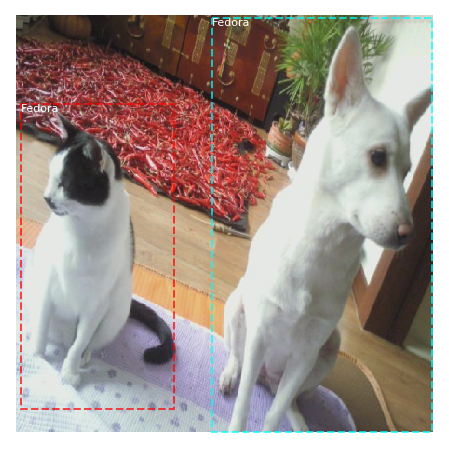

[[105.631232 223.111168 139.806016 399.111104]]
(1, 4)
(1,)
0
showing box
Pig at [105.631232 223.111168 139.806016 399.111104]


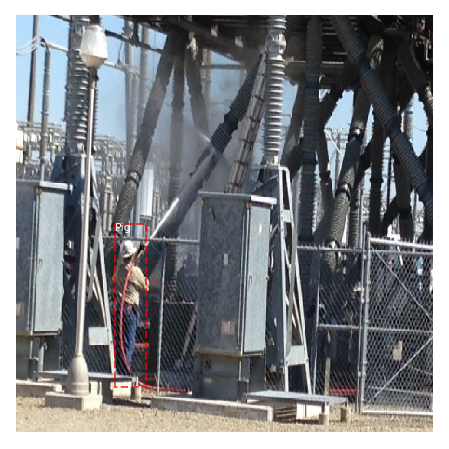

[[ 77.301952  83.049792 253.866816 299.446336]
 [275.827328 142.705024 382.996096 283.070592]]
(2, 4)
(2,)
0
showing box
Human leg at [ 77.301952  83.049792 253.866816 299.446336]
1
showing box
Human leg at [275.827328 142.705024 382.996096 283.070592]


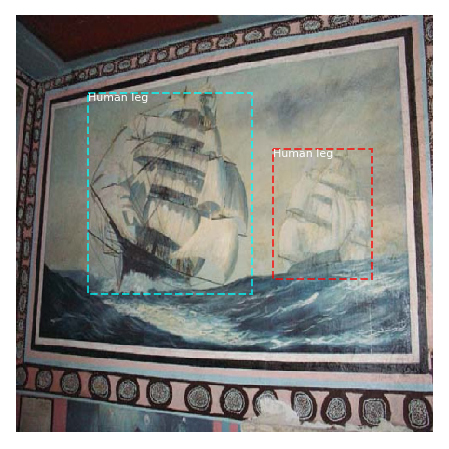

[[  2.447872 136.565184  98.53536  436.342144]
 [  0.       224.        63.03808  447.167168]
 [313.96736  103.256384 447.388032 377.219136]
 [235.628288  18.319616 447.388032 384.713728]
 [ 59.366272 211.509312  81.398912 256.475968]
 [339.060288  32.475968 388.633728 130.736256]]
(6, 4)
(6,)
0
showing box
Sandal at [  2.447872 136.565184  98.53536  436.342144]
1
showing box
Ski at [  0.       224.        63.03808  447.167168]
2
showing box
Ski at [313.96736  103.256384 447.388032 377.219136]
3
showing box
Sandal at [235.628288  18.319616 447.388032 384.713728]
4
showing box
Bidet at [ 59.366272 211.509312  81.398912 256.475968]
5
showing box
Bidet at [339.060288  32.475968 388.633728 130.736256]


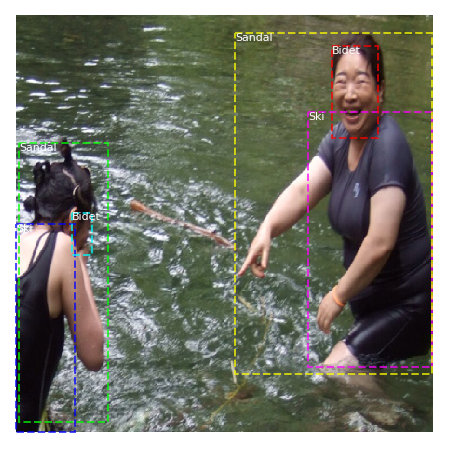

In [22]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 4)
print(image_ids)
for image_id in image_ids:
    img = dataset_val.load_image(image_id)
    bboxes, class_ids = dataset_val.load_bboxes(image_id)
    bboxes = np.array(bboxes)
    print(bboxes.shape)
    
    class_ids = np.array(class_ids)
    print(class_ids.shape)
    
    visualize.display_instances(img, bboxes, class_ids, dataset_train.class_names, figsize=(8, 8))

## Create Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", 
                          config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox = datagen.load_image_gt(dataset_val, inference_config, image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)

visualize.display_instances(original_image, gt_bbox, gt_class_id, dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox = datagen.load_image_gt(dataset_val, inference_config, image_id)
    molded_images = np.expand_dims(meta.mold_image(image, inference_config), 0)
    
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))